# Install Libraries
Install information can be found [here](https://www.archrproject.com/index.html)\
Vignette [here](https://www.archrproject.com/articles/Articles/tutorial.html)

In [2]:
#ArchR parameters
atac_frag # Input file atac_frag.tsv.bgz 
genome #either hg38 or mm10

#ArchR QC
min_tss = 4 #The minimum numeric transcription start site (TSS) enrichment score required for a cell to pass filtering
min_frags = 1000 #The minimum number of mapped ATAC-seq fragments required per cell to pass filtering for use
add_tile_mat = TRUE #A boolean value indicating whether to add a "Tile Matrix" to each ArrowFile. 
add_gene_score_mat = TRUE #A boolean value indicating whether to add a Gene-Score Matrix to each ArrowFile.

#ArchR Doublet paramaters
doublet_k = 10 #The number of cells neighboring a simulated doublet to be considered as putative doublets.
doublet_knn_method = "UMAP" #Refers to the embedding to use for nearest neighbor search.
lsi_method = 1 #A number or string indicating the order of operations in the TF-IDF normalization. Possible values are: 1 or "tf-logidf", 2 or "log(tf-idf)", and 3 or "logtf-logidf". 

copy_arrow_files = TRUE #save a copy of arrow files in the ArchR project (recommended)
iter_LSI_matrix = "TileMatrix" #The name of the data matrix to retrieve from the ArrowFiles associated with the ArchRProject. Valid options are "TileMatrix" or "PeakMatrix".
threads = 1
prefix = "prefix" #project name

#ArchR Plots parameters
marker_features_test = "wilcoxon" #The name of the pairwise test method to use in comparing cell groupings to the null cell grouping during marker feature identification.
heatmap_transpose = TRUE #Boolean to transpose heatmap
heatmap_label_n = 5 #Top n genes to label per cluster in heatmap
heatmap_cutoff = "FDR <= 0.01 & Log2FC >= 0.5" #Cut-off applied to genes in heatmap

#Terra specific parameters
table_name = "demux_BH3KTLDMXY"
experiment_name = "gm12878_fresh_ATAC"

#papermill specific parameters
papermill = FALSE

#jupyter notebook plot sizes
options(repr.plot.width=15, repr.plot.height=15)


In [3]:
papermill <- as.logical(papermill)
add_tile_mat <- as.logical(add_tile_mat)
add_gene_score_mat <- as.logical(add_gene_score_mat)
copy_arrow_files <- as.logical(copy_arrow_files)
heatmap_transpose <- as.logical(heatmap_transpose)

In [68]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cran.r-project.org")
if (!requireNamespace("devtools", quietly = TRUE)) 
    install.packages("devtools")
if (!requireNamespace("GenomeInfoDbData", quietly = TRUE))
    BiocManager::install("GenomeInfoDbData")
if (!requireNamespace("GenomicRanges", quietly = TRUE))
    BiocManager::install("GenomicRanges")
if (!requireNamespace("Rsamtools", quietly = TRUE))
    BiocManager::install("Rsamtools")
if (!requireNamespace("presto", quietly = TRUE))
    devtools::install_github('immunogenomics/presto')
if (!requireNamespace("magick", quietly = TRUE))
    install.packages("magick")
if (!requireNamespace("ArchR", quietly = TRUE)){
    devtools::install_github('GreenleafLab/ArchR@v1.0.1', repos = BiocManager::repositories())
    ArchR::installExtraPackages()
}

In [4]:
suppressMessages(library(parallel))
suppressMessages(library(ArchR))
suppressMessages(library(magick))
set.seed(1)
addArchRThreads(threads = threads) 

Setting default number of Parallel threads to 1.



In [70]:
#Function to save plots
dir.create("plots", showWarnings=F)
printPNG <- function(name, plotObject, papermill, wf=1, hf=1){
    filename = paste0(prefix,".atac.archr.",name,".",genome)
	options(repr.plot.width = 7*wf, repr.plot.height = 7*hf)
	print(plotObject)
	if(papermill){
		png(sprintf("plots/%s.png", filename), width=480*wf, height=480*hf)
		print(plotObject)
		dev.off()
	}
}

In [ ]:
#Terra specific code block
get_file <- function(path){
    dest <- getwd()
    gsutil_cp(path, dest)
    name <- basename(path)
    return(name)
}

if (!papermill){
    table <- avtable(table_name)
    atac_frag <- get_file(table$atac_fragment_file_raw[table[, sprintf('%s_id', table_name)] == experiment_name])
}

In [5]:
addArchRGenome(genome)

Setting default genome to Mm10.



In [72]:
ArrowFiles <- createArrowFiles(
  inputFiles = atac_frag,
  sampleNames = prefix,
  minTSS = min_tss, 
  minFrags = min_frags,
  addTileMat = add_tile_mat,
  addGeneScoreMat = add_gene_score_mat,
)
ArrowFiles

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

ArchR logging to : ArchRLogs/ArchR-createArrows-31f24ee503f4-Date-2022-03-10_Time-13-59-02.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-03-10 13:59:02 : Batch Execution w/ safelapply!, 0 mins elapsed.

(prefix : 1 of 1) Determining Arrow Method to use!

2022-03-10 13:59:02 : (prefix : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0 mins elapsed.

2022-03-10 13:59:02 : (prefix : 1 of 1) Tabix Bed To Temporary File, 0 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one argument not used by format '%s Reading TabixFile %s Percent'”
2022-03-10 13:59:14 : (prefix : 1 of 1) Reading TabixFile 10 Percent, 0.195 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one argument not used by format '%s Reading TabixFile %s Percen

[1] "prefix.arrow"

In [73]:
doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = doublet_k,
  knnMethod = doublet_knn_method,
  LSIMethod = lsi_method
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-31f21473113-Date-2022-03-10_Time-14-09-30.log
If there is an issue, please report to github with logFile!

2022-03-10 14:09:30 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-03-10 14:09:30 : prefix (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

prefix (1 of 1) : UMAP Projection R^2 = 0.92393

prefix (1 of 1) : UMAP Projection R^2 = 0.92393

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-31f21473113-Date-2022-03-10_Time-14-09-30.log



In [74]:
proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = prefix,
  copyArrows = copy_arrow_files, #This is recommened so that you maintain an unaltered copy for later usage.
  showLogo = FALSE
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...



In [ ]:
#Uncomment next line to filter doublets

#proj <- filterDoublets(ArchRProj = proj) 

In [75]:
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = iter_LSI_matrix, name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-31f2e397a4a-Date-2022-03-10_Time-14-13-50.log
If there is an issue, please report to github with logFile!

2022-03-10 14:13:51 : Computing Total Across All Features, 0 mins elapsed.

2022-03-10 14:13:51 : Computing Top Features, 0.015 mins elapsed.

###########
2022-03-10 14:13:53 : Running LSI (1 of 2) on Top Features, 0.038 mins elapsed.
###########

2022-03-10 14:13:53 : Creating Partial Matrix, 0.038 mins elapsed.

2022-03-10 14:13:55 : Computing LSI, 0.075 mins elapsed.

2022-03-10 14:14:00 : Identifying Clusters, 0.165 mins elapsed.

2022-03-10 14:14:02 : Identified 6 Clusters, 0.198 mins elapsed.

2022-03-10 14:14:02 : Saving LSI Iteration, 0.198 mins elapsed.

2022-03-10 14:14:10 : Creating Cluster Matrix on the total Group Features, 0.33 mins elapsed.

2022-03-10 14:14:28 : Computing Variable Features, 0.623 mins elapsed.

###########
2022-03-10 14:14:28 : Running LSI (2 of 2) on Variable Features, 0.625 mi

In [76]:
proj <- addClusters(input = proj, reducedDims = "IterativeLSI") #from the ArchR docs, IterativeLSI is the only supported option for reducedDims 

ArchR logging to : ArchRLogs/ArchR-addClusters-31f26287e5d3-Date-2022-03-10_Time-14-17-27.log
If there is an issue, please report to github with logFile!

2022-03-10 14:17:27 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1306
Number of edges: 100265

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6854
Number of communities: 6
Elapsed time: 0 seconds


2022-03-10 14:17:29 : Testing Outlier Clusters, 0.031 mins elapsed.

2022-03-10 14:17:29 : Assigning Cluster Names to 6 Clusters, 0.031 mins elapsed.

2022-03-10 14:17:29 : Finished addClusters, 0.032 mins elapsed.



In [77]:
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI")

14:17:42 UMAP embedding parameters a = 0.7669 b = 1.223

14:17:42 Read 1306 rows and found 30 numeric columns

14:17:42 Using Annoy for neighbor search, n_neighbors = 40

14:17:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:17:42 Writing NN index file to temp file /var/folders/c3/cr8rqqls3gn0r7h2cq16rxg80000gp/T//Rtmpztoxoo/file31f24801b22e

14:17:42 Searching Annoy index using 8 threads, search_k = 4000

14:17:42 Annoy recall = 100%

14:17:43 Commencing smooth kNN distance calibration using 8 threads

14:17:44 Initializing from normalized Laplacian + noise

14:17:44 Commencing optimization for 500 epochs, with 82102 positive edges

14:17:46 Optimization finished

14:17:46 Creating temp model dir /var/folders/c3/cr8rqqls3gn0r7h2cq16rxg80000gp/T//Rtmpztoxoo/dir31

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-31f22718a4a-Date-2022-03-10_Time-15-17-21.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-31f22718a4a-Date-2022-03-10_Time-15-17-21.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-31f26c2e0186-Date-2022-03-10_Time-15-17-21.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-31f26c2e0186-Date-2022-03-10_Time-15-17-21.log



pdf 
  2

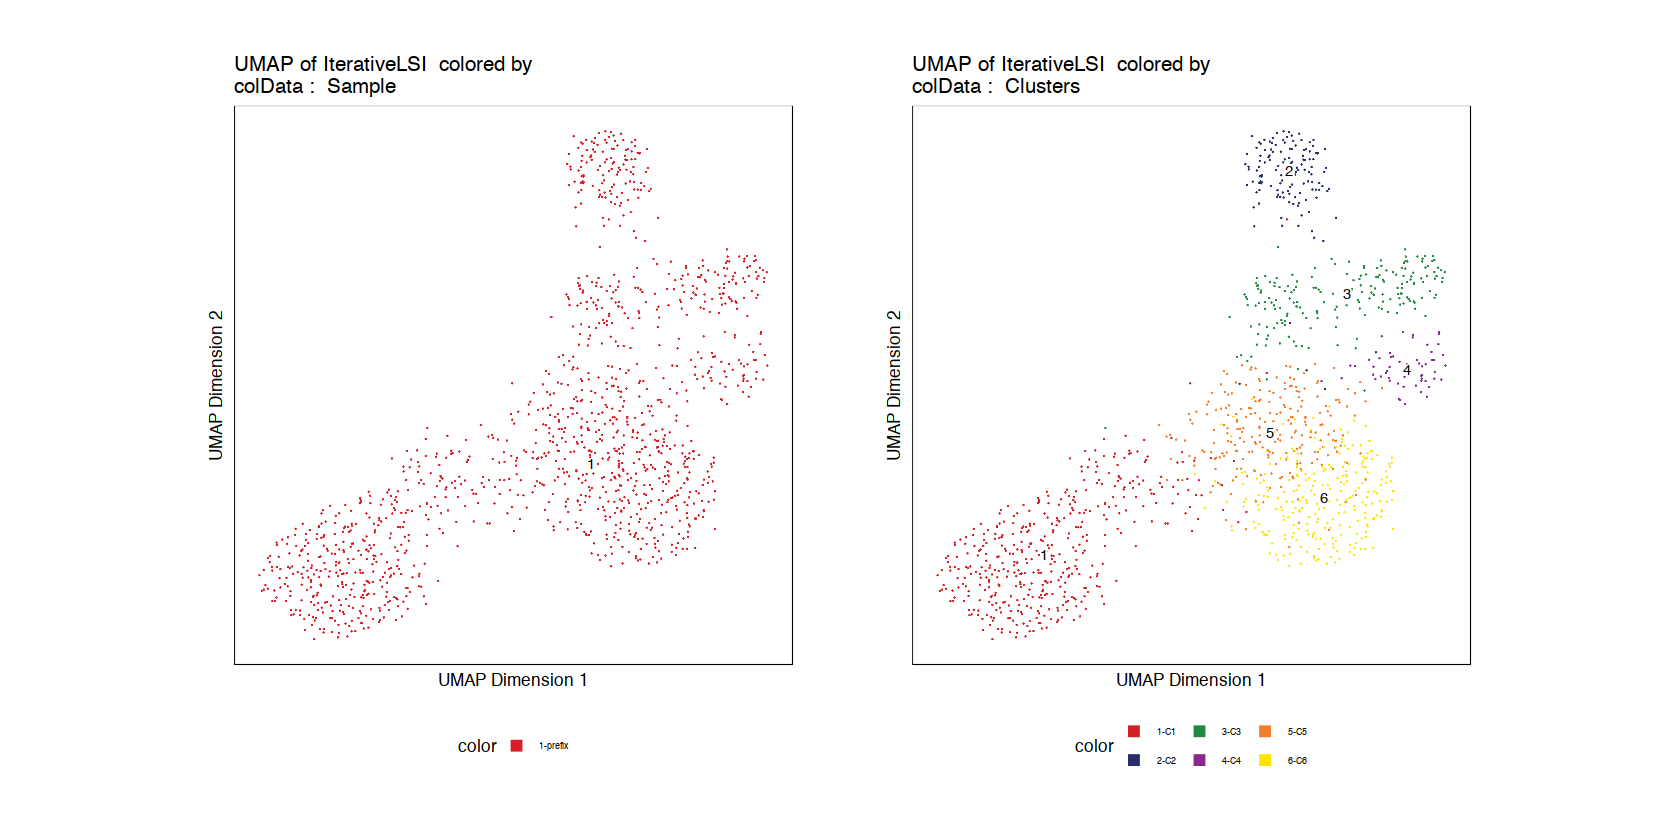

In [78]:
#Plot UMAP

p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
obj <- p1 + p2 #ggAlignPlots(p1, p2, type = "h")
printPNG('umap', obj, papermill, wf=2)

pdf 
  2

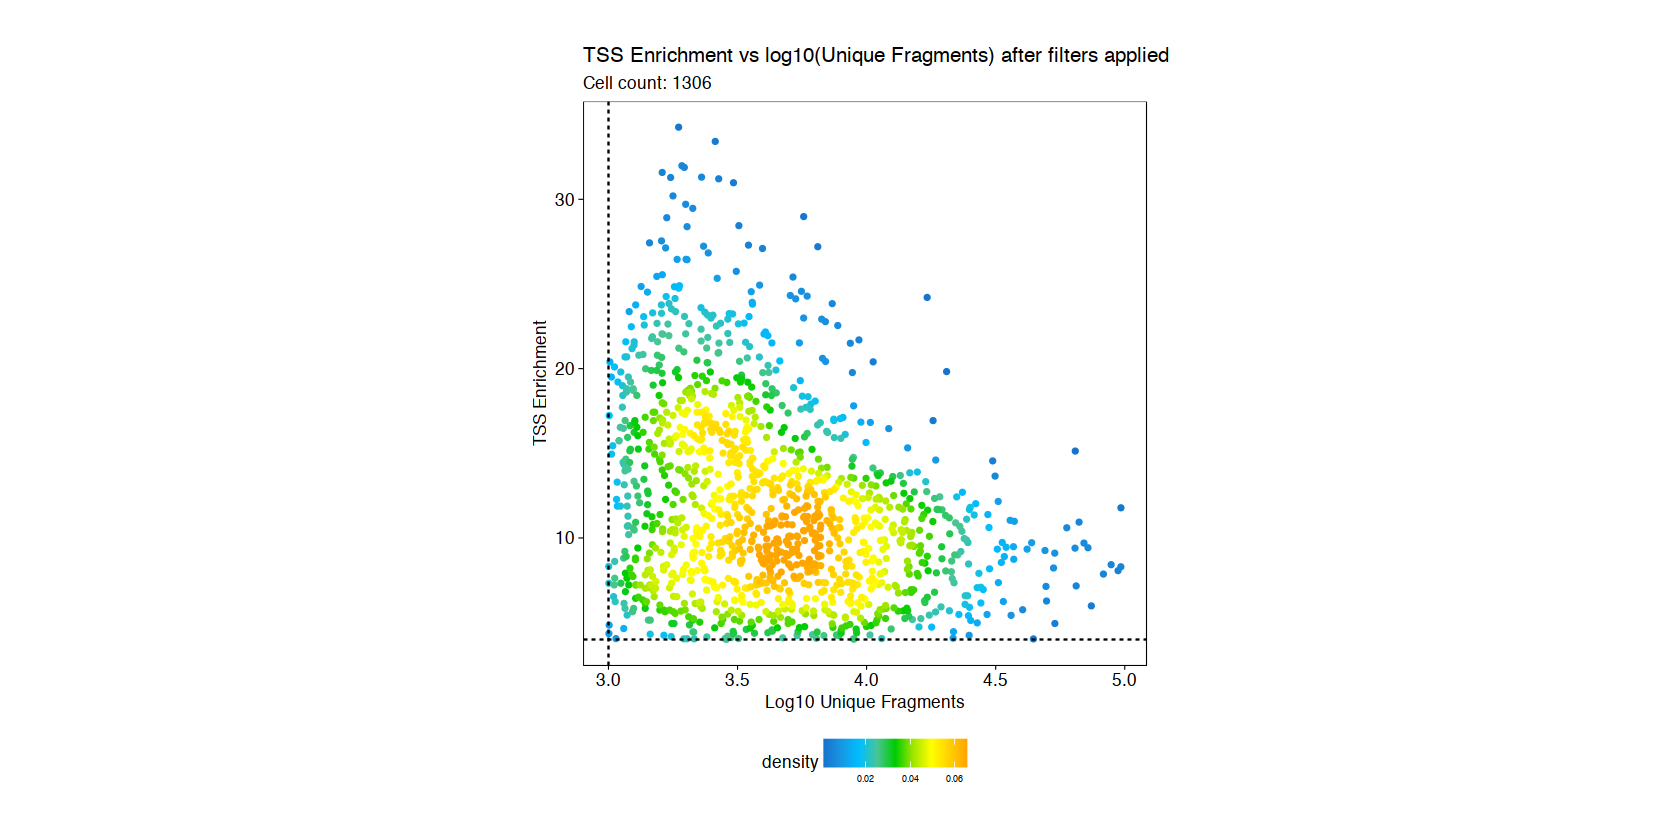

In [79]:
#Plot TSS Enrichment vs Unique Fragments QC plot

df <- getCellColData(proj, select = c("log10(nFrags)", "TSSEnrichment"))
p <- ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment"
) + geom_hline(yintercept = min_tss, lty = "dashed") + geom_vline(xintercept = log10(min_frags), lty = "dashed") + ggtitle(label = "TSS Enrichment vs log10(Unique Fragments) after filters applied", subtitle = paste0("Cell count: ", dim(df)[1]))
printPNG('TSS_fragment_qc', p, papermill, wf=2)


In [80]:
#Extract marker genes

# single core worked, multicore breaks 
markersGS <- getMarkerFeatures(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = marker_features_test
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-31f2448d0f96-Date-2022-03-10_Time-15-17-30.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2022-03-10 15:17:30 : Matching Known Biases, 0.001 mins elapsed.

2022-03-10 15:17:31 : Computing Pairwise Tests (1 of 6), 0.009 mins elapsed.

Pairwise Test C1 : Seqnames chr1

Pairwise Test C1 : Seqnames chr10

Pairwise Test C1 : Seqnames chr11

Pairwise Test C1 : Seqnames chr12

Pairwise Test C1 : Seqnames chr13

Pairwise Test C1 : Seqnames chr14

Pairwise Test C1 : Seqnames chr15

Pairwise Test C1 : Seqnames chr16

Pairwise Test C1 : Seqnames chr17

Pairwise Test C1 : Seqnames chr18

Pairwise Test C1 : Seqnames chr19

Pairwise Test C1 : Seqnames chr2

Pairwise Test C1 : Seqnames chr3

Pairwise Test C1 : Seqnames chr4

Pairwise Test C1 : Seqnames chr5

Pairwise Test C1 : Seqnames chr6

Pairwise Test C1 : Seqnames chr7

Pairwise Test C1 : Seqnames chr8

Pairwise Test C1 : Seqnames chr9

Pai

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-31f28fa6403-Date-2022-03-10_Time-15-19-22.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	St18, Rims1, Col19a1, Amer3, Nab1, Als2, Cdk15, 6030407O03Rik, Gm15179, Speg, Sgpp2, Scg2, Sphkap, Gm20268, Cdh7

C2:

	Ptp4a1, Fam178b, Tmeff2, Plcl1, BC055402, Cyp27a1, Dock10, Efhd1, Phlpp1, Nckap5, Pik3c2b, Csrp1, Phlda3, Tnni1, Mroh3

C3:

	Rgl1, Itpkb, Gm5069, Enah, Chst11, Msi2, 0610039H22Rik, C030037D09Rik, Pitpnc1, BC006965, Socs3, 9430078K24Rik, Zfp36l1, Mmp14, Lifr

C4:

	St18, Rims1, Col19a1, Ptp4a1, Amer3, Fam178b, Tmeff2, Nab1, Plcl1, BC055402, Als2, Cdk15, 6030407O03Rik, Cyp27a1, Gm15179

C5:

	St18, Rims1, Col19a1, Ptp4a1, Amer3, Fam178b, Tmeff2, Nab1, Plcl1, BC055402, Als2, Cdk15, 6030407O03Rik, Cyp27a1, Gm15179

C6:

	Cacna1e, Syt14, Rrp1, Zfr2, Syt1, Nsg2, Fbll1, Tenm2, Cyfip2, Gria1, Klhl29, Myt1l, C630031E19Rik, Ppp4r4, Mirg

Identified 925 markers!



 [1] "St18"     "Rims1"    "Col19a1"  "Amer3"    "Nab1"     "Ptp4a1"  
 [7] "Fam178b"  "Tmeff2"   "Plcl1"    "BC055402" "Rgl1"     "Itpkb"   
[13] "Gm5069"   "Enah"     "Chst11"   "Cacna1e"  "Syt14"    "Rrp1"    
[19] "Zfr2"     "Syt1"    


Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-31f28fa6403-Date-2022-03-10_Time-15-19-22.log



pdf 
  2

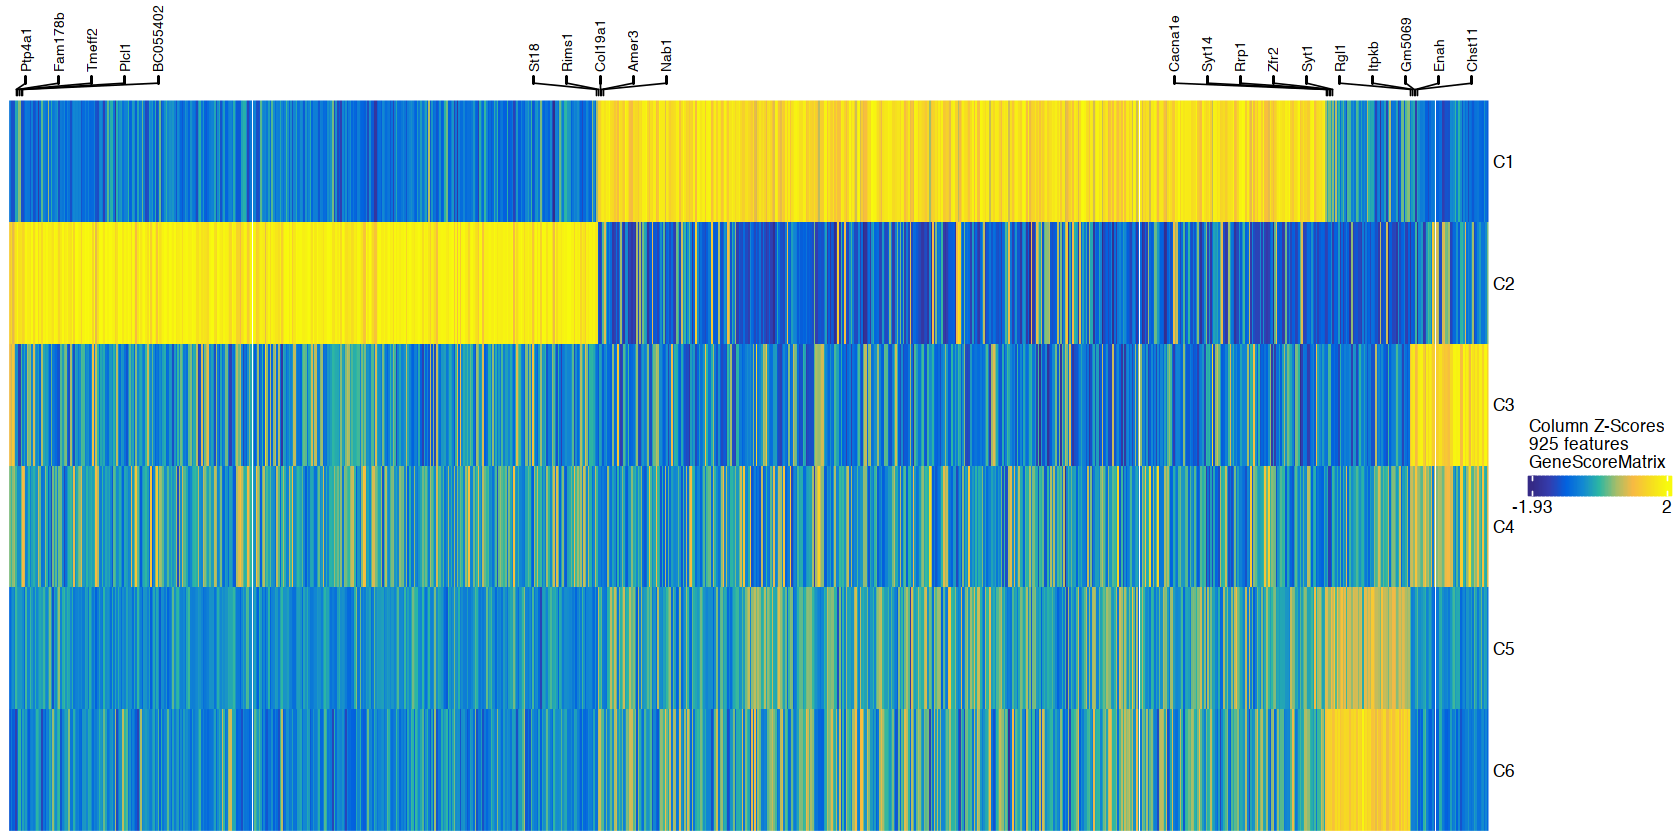

In [81]:
#Plot heatmap of upregulated genes in clusters

hm = plotMarkerHeatmap(markersGS, transpose = heatmap_transpose, nLabel = heatmap_label_n, cutOff = heatmap_cutoff)
printPNG('heatmap', hm, papermill, wf=2)

In [82]:
#Create final output files

files2zip <- dir('plots/', full.names = TRUE)
zip(zipfile = 'plots.zip', files = files2zip)

saveRDS(proj, file = paste0(prefix,".atac.archr.rds.",genome,".rds"))

In [7]:
tmp = readRDS("prefix.atac.archr.rds.mm10.rds")

In [11]:
markersGS <- getMarkerFeatures(
    ArchRProj = tmp, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = marker_features_test
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-85b57e10f781-Date-2022-03-11_Time-07-59-06.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2022-03-11 07:59:06 : Matching Known Biases, 0.002 mins elapsed.

2022-03-11 07:59:08 : Computing Pairwise Tests (1 of 6), 0.022 mins elapsed.

Pairwise Test C1 : Seqnames chr1

Pairwise Test C1 : Seqnames chr10

Pairwise Test C1 : Seqnames chr11

Pairwise Test C1 : Seqnames chr12

Pairwise Test C1 : Seqnames chr13

Pairwise Test C1 : Seqnames chr14

Pairwise Test C1 : Seqnames chr15

Pairwise Test C1 : Seqnames chr16

Pairwise Test C1 : Seqnames chr17

Pairwise Test C1 : Seqnames chr18

Pairwise Test C1 : Seqnames chr19

Pairwise Test C1 : Seqnames chr2

Pairwise Test C1 : Seqnames chr3

Pairwise Test C1 : Seqnames chr4

Pairwise Test C1 : Seqnames chr5

Pairwise Test C1 : Seqnames chr6

Pairwise Test C1 : Seqnames chr7

Pairwise Test C1 : Seqnames chr8

Pairwise Test C1 : Seqnames chr9

Pai